# Tutorial 3 - Support Vector Machines and Kernel Methods

We look to 

1.   Write a solver that learns the parameters of a linear SVM  model

2.   Use the  scikit-learn  library for  different type of kernels

3.   Apply these methods on  MNIST  dataset and evaluate different design issues.

## Linear SVM

### Fundamentals

The purpose of this section is to develop our own class and solver that trains a  soft margin linear SVM  for a given dataset. 

 Input:  $(x^i,y^i)_{i \in \{1,\dotsc,m\}}$ where 

- $m \in \mathbb{N}$ is the *number* of samples in the dataset

- $n \in \mathbb{N}$ is the number of features

- $x^i \in \mathbb{R}^n$  is an $n$ dimensional input vector for the $i^{\textit{th}}$ sample

- $y^i \in \mathbb{R}$ is the numeric output value associated with sample $i$

 Output: The goal is to fit a hyperplane $h(x)=w^Tx+b=0$ by solving the following quadratic program:

\begin{align}
         \underset{w,b,\xi}{\min} & \frac{1}{2}||w||^2_2 + C\frac{1}{m}\sum_{i=1}^m \xi_i\\
        \mathrm{s.t.} & \quad y^i(w^Tx^i+b) \geq 1 - \xi_i & \forall i \in \{1,\dotsc,m\}\\
        & \quad \xi_i \geq 0 & \forall i \in \{1,\dotsc,m\}
\end{align}
where $C$ is the regularization parameter.

Recall that this problem can be also solved using gradient descent by minimizing the loss function below :

\begin{align}
\underset{w,b}{\min}\frac{1}{2}||w||_2^2+C\frac{1}{m}\sum_{i=1}^m\big(1-y^i(w^Tx^i+b)\big)^+
\end{align}
where $(a)^+ := \max\{0,a\}$ 

Next, we derive the formula for the gradient of the objective function to be used in SGD. But before that, we express the math in a more compact way.

Let us modify the input matrix $X$ and the coefficient vector $w$, respectively as following:

\begin{align}
\tilde{X}=\begin{bmatrix} 
1& x^1_{1} & \dots  & x^1_{n}\\
\vdots & \vdots & \ddots & \vdots\\
1& x^m_{1} & \dots  & x^m_{n} 
\end{bmatrix}_{m\times(n+1)}, \quad  \tilde{w}=\begin{bmatrix} b \\ w_1 \\ \vdots \\ w_{n} \end{bmatrix}_{(n+1) \times 1}
\end{align} 

Then, the loss function can be rewritten in the form of

\begin{align}
\mathcal{J}(\tilde{w}) &= \frac{1}{2}||\tilde{w}||_2^2+C\frac{1}{m}\sum_{i=1}^m\big(1-y^i \tilde{w}^T\tilde{x}^i\big)^+ \\
\mathcal{J}(\tilde{w}) & = \frac{1}{m}\sum_{i=1}^m \Big[\frac{1}{2}||\tilde{w}||_2^2 + C \big(1-y^i\tilde{w}^T\tilde{x}^i\big)^+\Big]\\
\nabla_{\tilde{w}}\mathcal{J}(\tilde{w}) &= \frac{1}{m}\sum_{i=1}^m \begin{cases}
\tilde{w}, & \text{if } \big(1-y^i\tilde{w}^T\tilde{x}^i \big)^+=0 \\
\tilde{w}-Cy^i\tilde{x}^i, & \text{otherwise}
\end{cases}
\end{align}

### Implementation

In [1]:
import numpy as np
from sklearn.utils import shuffle

class LinearSVM:
    
    def __init__(self, C):
        """
        Initialize the model by setting the regularization parameter 'C'
        and our weights (weights are initially 'None')

        @ Params:
        ---------
        C: float, scalar
        """
        self.C = C
        self.w = None  
    
    def add_bias_term(self, X):
        """
        Add intercept 1 to each training example for bias b

        @ Params:
        ---------
        X: 2D numpy array with dim (n_sample, n_feature)

        @ Return:
        2D numpy array with dim (n_sample, n_feature+1)
        """
        return np.c_[np.ones((X.shape[0],1)), X]
    
    def compute_cost(self, w, X, y):
        """
        Compute the value of the cost function

        @ Params:
        ---------
        X: 2D numpy array with dim (n_sample, n_feature+1)
        y: 1D numpy array with dim (n_sample, 1)
        w: 1D numpy array with dim (n_feature+1, 1)

        @ Return:
        ---------
        float, scalar
        """
        n_samples = X.shape[0]
        
        # Compute hinge loss 
        predictions = np.dot(X, w).flatten()
        distances = 1 - y * predictions
        hinge_losses = np.maximum(0, distances)

        # Compute sum of the individual hinge losses
        sum_hinge_loss = np.sum(hinge_losses) / n_samples

        # Compute entire cost
        cost = (1 / 2) * np.dot(w.T, w) + self.C * sum_hinge_loss
        
        return float(cost)
    
    def compute_gradient(self, w, X, y):
        """
        Compute the gradient, needed for training

        @ Params:
        ---------
        X: 2D numpy array with dim (n_sample, n_feature+1)
        y: 1D numpy array with dim (n_sample, 1)
        w: 1D numpy array with dim (n_feature+1, 1)

        @ Return:
        ---------
        np.ndarray with dim (n_feature+1, 1)
        """
        predictions = np.dot(X, w)
        distances = 1 - y * predictions
        n_samples, n_dim = X.shape
        sub_gradients = np.zeros((1, n_dim))

        for idx, dist in enumerate(distances):
            if max(0, dist) == 0:
                sub_gradients += w.T
            else:
                sub_grad = w.T - (self.C * X[idx] * y[idx])
                sub_gradients += sub_grad
        return sum(sub_gradients) / len(y)
    
    def train(self, X, y, n_epochs, learning_rate=0.01, batch_size=1):
        """
        Train the model with stochastic gradient descent using the
        specified number of epochs, learning rate and batch size.

        @ Params:
        ---------
        X: 2D numpy array with dim (n_sample, n_feature+1)
        y: 1D numpy array with dim (n_sample, 1)
        n_epochs: integer

        @ Return:
        ---------
        %inplace%
        """
        # Add bias term to features
        X = self.add_bias_term(X)
        
        # Initalize weight vector
        n_samples, n_dim = X.shape
        weights = np.zeros(n_dim)[:, np.newaxis]
        
        # Train the model for a certain number of epochs
        for epoch in range(n_epochs):
            features, labels = shuffle(X, y)
            features, labels = X, y
            start, end = 0, batch_size
            while end <= len(labels): # Training loop over the dataset
                batch = features[start:end]
                batch_labels = labels[start:end]
                
                grad = self.compute_gradient(weights, batch, batch_labels)
                update = (learning_rate * grad)[:, np.newaxis]
                weights = weights - update
                start, end = end, end + batch_size
                
            current_cost = self.compute_cost(weights, features, labels)
            print(f"Epoch {epoch + 1}, cost: {current_cost}")
                
        # Set the trained weights to allow making predictions
        self.trained_weights = weights
    
    def predict(self, test_features) -> np.ndarray:
        """
        Predict labels for new test features.
        Raises ValueError if model has not been trained yet.
        """
        test_features = self.add_bias_term(test_features)
        if self.trained_weights is None:
            raise ValueError("You haven't trained the SVM yet!")
            
        predicted_labels = []
        n_samples = test_features.shape[0]
        for idx in range(n_samples):
            prediction = np.sign(np.dot(self.trained_weights.T, test_features[idx]))
            predicted_labels.append(prediction)
            
        return np.array(predicted_labels)

 The algorithm have been designed to work for any dimension of input space. However, for the sake of illustration and better visualization, we use 2 features. 

In order to get the problem instance, we will use scikit-learn:

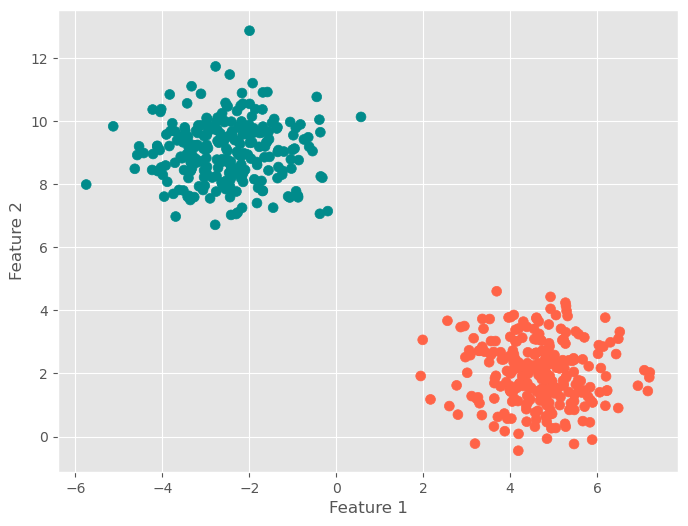

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=42)

# The function outputs targets 0 and 1 so we need to convert targets 0 to -1
y = [-1 if t == 0 else +1 for t in y]
        
# Plot the dataset
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, c=['tomato' if i==1 else 'darkcyan' for i in y])
plt.ylabel("Feature 2")
plt.xlabel("Feature 1")
plt.show()

In [3]:
regularization_param = 100
lr = 0.000001
svm = LinearSVM(regularization_param)
trained_weights = svm.train(X, y, n_epochs=10, learning_rate=lr)

Epoch 1, cost: 23.91419970856241
Epoch 2, cost: 5.733425355498088
Epoch 3, cost: 2.9410662962428638
Epoch 4, cost: 2.154995931110475
Epoch 5, cost: 1.771753561847649
Epoch 6, cost: 1.5023954550856409
Epoch 7, cost: 1.3149429740498655
Epoch 8, cost: 1.186267070372377
Epoch 9, cost: 1.0769228003117317
Epoch 10, cost: 0.985763513277068


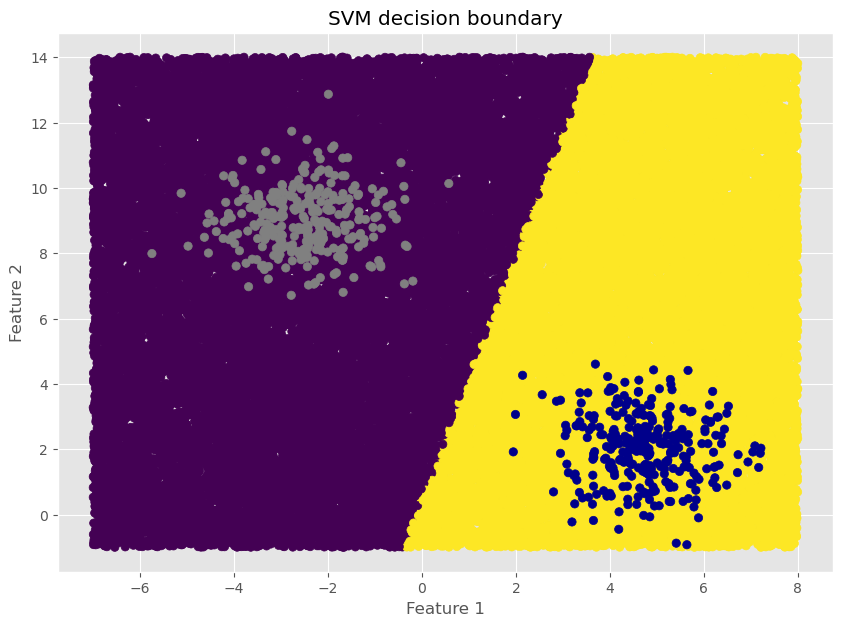

In [4]:
# Create dataset for visualization
size=40000
feat_1 = np.random.uniform(low=-7, high=8, size=size)
feat_2 = np.random.uniform(low=-1, high=14, size=size)
features_vis = np.column_stack((feat_1, feat_2))

labels_vis = svm.predict(features_vis)

# Plot the decision boundary
plt.figure(figsize=(10, 7))
plt.scatter(features_vis[:, 0], features_vis[:, 1], c = labels_vis)
features, targets = make_blobs(n_samples=600, centers=2, n_features=2, random_state=42)
plt.scatter(features[:, 0], features[:, 1], c=['darkblue' if i==1 else 'gray' for i in targets] )
plt.title("SVM decision boundary")
plt.ylabel("Feature 2")
plt.xlabel("Feature 1")
plt.show()

## Beyond linear boundaries: Kernel Machines

In practice , linear separation is often not possible and a more complex function to separate the data is needed. At this point, kernel machines project the data into higher-dimensional space defined by kernel functions, and thereby are able to fit for nonlinear relationships with a linear classifier.

To motivate the need for kernels, we consider some data that is not linearly separable:

C:\Users\44746\AppData\Local\Temp\ipykernel_33308\1871489949.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')


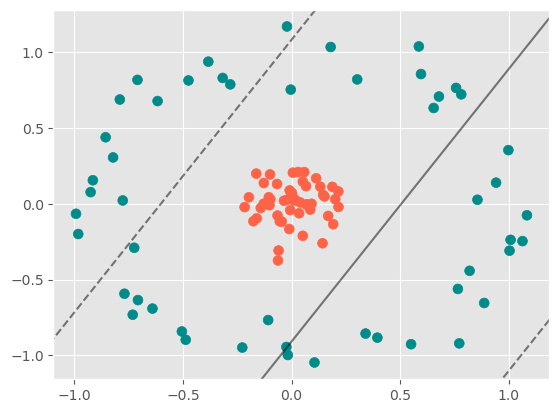

In [5]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

from sklearn.datasets import make_circles
from sklearn.svm import SVC

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);


It is clear that no linear discrimination will ever be able to separate this data. Let's use radial basis function to convert data into a higher dimensional space.

In [6]:
r = np.exp(-(X ** 2).sum(1))

Let's visualize the new space.

C:\Users\44746\AppData\Local\Temp\ipykernel_33308\3430505015.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(X[:, 0], X[:, 1], r, c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')


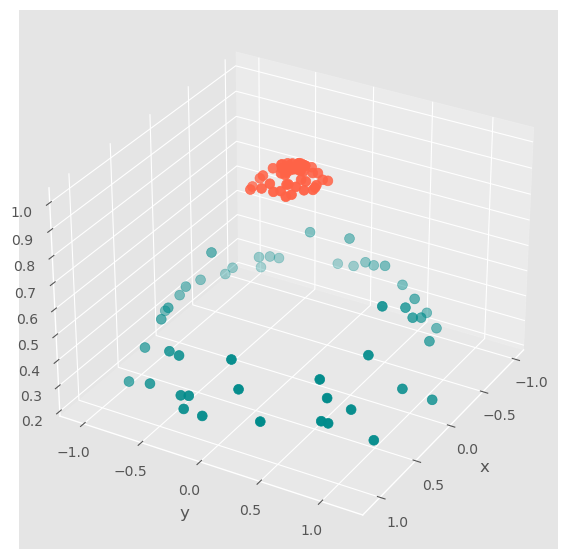

In [7]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(10,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D()

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [8]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

C:\Users\44746\AppData\Local\Temp\ipykernel_33308\1281499080.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')


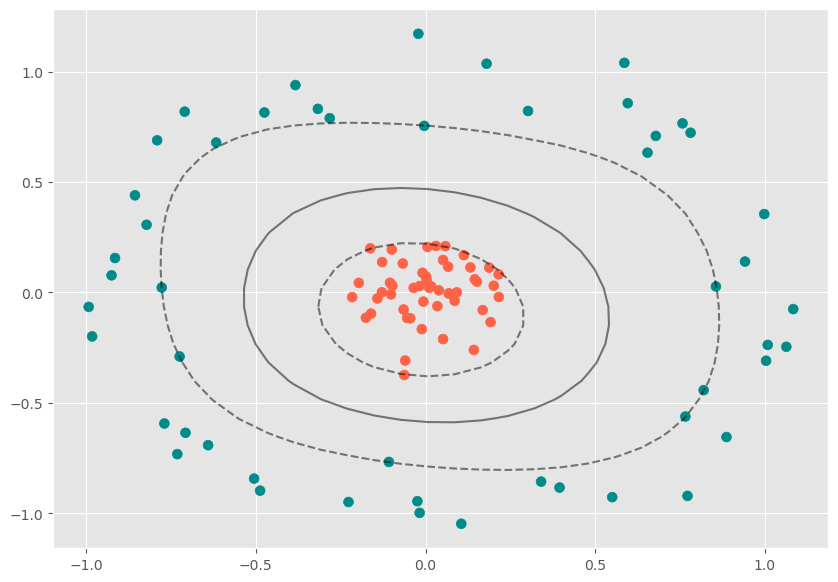

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=['tomato' if i==1 else 'darkcyan' for i in y], s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

## Application to MNIST Dataset

MNIST data is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label. Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features.



we load the data

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

X = X/255.0 # normalize data (We save a lot of time by keeping the data that way)

print(f'type of x: {type(X)}')
print(f'shape of x: {X.shape}')
print(f'type of y: {type(y)}')
print(f'shape of y: {y.shape}')

c:\Users\44746\anaconda3\envs\mml\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


type of x: <class 'numpy.ndarray'>
shape of x: (70000, 784)
type of y: <class 'numpy.ndarray'>
shape of y: (70000,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (46900, 784)
X_test shape: (23100, 784)
y_train shape: (46900,)
y_test shape: (23100,)


As an example, let's visualize the first point in the training data

Text(0.5, 1.0, 'First sample')

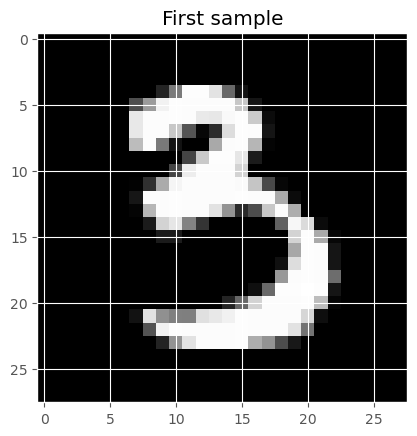

In [12]:
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
plt.title("First sample")

We can start with linear SVM as a benchmark.

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

svm = LinearSVC(dual=False)
svm.fit(X_train, y_train)
y_hat = svm.predict(X_test)
print(f'accuracy (%): {round(100 * accuracy_score(y_test, y_hat),2)}')

accuracy (%): 91.24


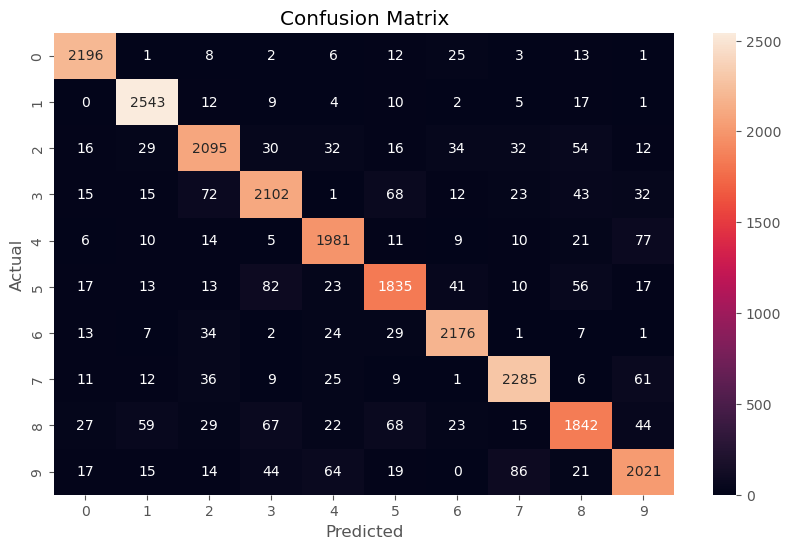

In [14]:
import seaborn as sb
cm = confusion_matrix(y_test, y_hat)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Running RBF SVC for multiple cost factor(s) C and Gamma

We choose sampling as running these many models would increase the time complexity as well. Considering time constraints we sample 10% of the data.

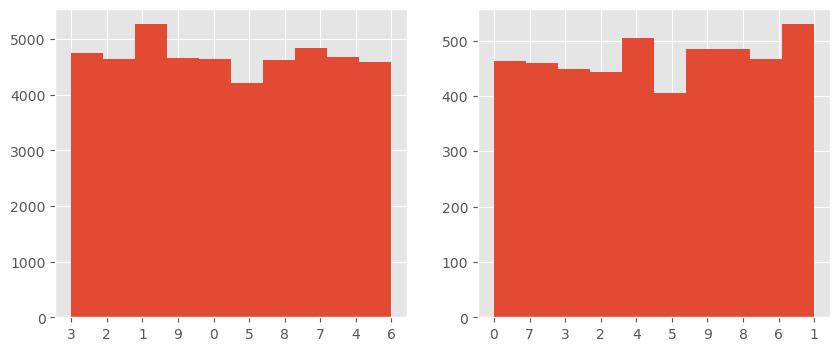

In [15]:
seq = np.random.randint(0,46900,4690)
X_train_samp = X_train[seq]
y_train_samp = y_train[seq]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_train)
ax[1].hist(y_train_samp)
fig.show
plt.show()

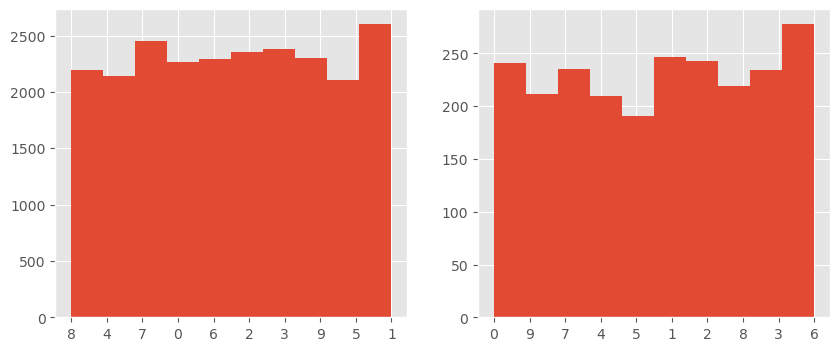

In [16]:
seq = np.random.randint(0,23100,2310)
X_test_samp = X_test[seq]
y_test_samp = y_test[seq]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_test)
ax[1].hist(y_test_samp)
fig.show
plt.show()

In [17]:
import pandas as pd
df = pd.DataFrame(columns = ['c','gamma', 'acc'])
i = 0
for c in [0.01, 0.1, 1, 10, 100]:
    for g in [0.01, 0.1, 1, 10, 100]:
        svm = SVC(kernel='rbf', C=c, gamma=g)
        model = svm.fit(X_train_samp, y_train_samp)
        y_hat = svm.predict(X_test_samp)
        acc = round(100 * accuracy_score(y_test_samp, y_hat),2)
        print(f'accuracy with C = {c} and Gamme = {g}: {acc}')
        df.loc[i] = [c,g,acc]
        i=i+1
df.sort_values(by='acc', ascending=False, inplace=True)

accuracy with C = 0.01 and Gamme = 0.01: 40.87
accuracy with C = 0.01 and Gamme = 0.1: 10.69
accuracy with C = 0.01 and Gamme = 1: 10.69
accuracy with C = 0.01 and Gamme = 10: 10.69
accuracy with C = 0.01 and Gamme = 100: 10.69
accuracy with C = 0.1 and Gamme = 0.01: 89.96
accuracy with C = 0.1 and Gamme = 0.1: 18.14
accuracy with C = 0.1 and Gamme = 1: 10.69
accuracy with C = 0.1 and Gamme = 10: 10.69
accuracy with C = 0.1 and Gamme = 100: 10.69
accuracy with C = 1 and Gamme = 0.01: 94.2
accuracy with C = 1 and Gamme = 0.1: 85.06
accuracy with C = 1 and Gamme = 1: 10.69
accuracy with C = 1 and Gamme = 10: 10.69
accuracy with C = 1 and Gamme = 100: 10.69
accuracy with C = 10 and Gamme = 0.01: 95.28
accuracy with C = 10 and Gamme = 0.1: 85.89
accuracy with C = 10 and Gamme = 1: 10.69
accuracy with C = 10 and Gamme = 10: 10.69
accuracy with C = 10 and Gamme = 100: 10.69
accuracy with C = 100 and Gamme = 0.01: 95.24
accuracy with C = 100 and Gamme = 0.1: 85.89
accuracy with C = 100 and Ga

In [18]:
df

,c,gamma,acc
15,10.00,0.01,95.28
20,100.00,0.01,95.24
10,1.00,0.01,94.20
5,0.10,0.01,89.96
21,100.00,0.10,85.89
16,10.00,0.10,85.89
11,1.00,0.10,85.06
0,0.01,0.01,40.87
6,0.10,0.10,18.14
23,100.00,10.00,10.69


we run the best option for the entire dataset and see what is going to be our new accuracy value. Recall that it was 91.16% with linear SVM.

In [19]:
svm = SVC(kernel='rbf', C=10, gamma=0.01)
model = svm.fit(X_train, y_train)
y_hat = svm.predict(X_test)
acc = round(100 * accuracy_score(y_test, y_hat),2)
print(f'new accuracy: {acc}%')

new accuracy: 98.0%
